In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import warnings

dataset_dir = "dataset"
warnings.filterwarnings("ignore")

: 

Preprocessing/Resizing the images

In [2]:
def normalize_image(image):
  image_array = np.array(image)
  normalized_array = image_array / 255.0
  return Image.fromarray((normalized_array * 255).astype(np.uint8))

def denoise_image(image):
  # Apply median filtering (adjust kernel size as needed)
  image = cv2.medianBlur(image, ksize=5)

  # Normalize the image
  return normalize_image(image)

def preprocess_image(image):
  return normalize_image(image)
  # no need for denoising now
  # denoise_image(image)

Preprocessing images by resizing and normalizing them.

Saving the new images in new train and test directories.

In [3]:
train_dataset_folder = f"{dataset_dir}/train"
train_output_folder = f"{dataset_dir}/resized_train"

test_dataset_folder = f"{dataset_dir}/test"
test_output_folder = f"{dataset_dir}/resized_test"

In [4]:
def resize_images(dataset_folder, output_folder, target_size, force_update=False):
    if os.path.isdir(output_folder) and len(os.listdir(output_folder)) != 0 and not force_update:
        return
    # Loop through all images in the dataset folder
    for filename in os.listdir(dataset_folder):
        # Skiping non-image files in case any
        if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        image_path = os.path.join(dataset_folder, filename)
        image = Image.open(image_path)

        resized_image = image.resize(target_size, Image.LANCZOS)

        if image.mode != 'RGB':
            resized_image = resized_image.convert('RGB')

        resized_image = preprocess_image(resized_image)

        # Saving the resized image
        output_path = os.path.join(output_folder, filename)
        resized_image.save(output_path)

os.makedirs(train_output_folder, exist_ok=True)
os.makedirs(test_output_folder, exist_ok=True)

resize_images(train_dataset_folder, train_output_folder, target_size=(224, 224))
resize_images(test_dataset_folder, test_output_folder, target_size=(224, 224))

In [5]:
def build_image_features_extraction_model():
    base_model = VGG16(weights='imagenet', include_top=True)
    # Retrieve the last dense layer name
    last_dense_layer_name = base_model.layers[-2].name
    # return Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    # Create a new model for feature extraction from the last dense layer
    return Model(inputs=base_model.input, outputs=base_model.get_layer(last_dense_layer_name).output)

In [6]:
def extract_image_features_as_list(feature_extractor, dir_path, max_iterations=-1):
    #train_output_folder
    features_list = []
    count = 0
    for filename in os.listdir(dir_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # Load and preprocess the image
            img_path = os.path.join(dir_path, filename)
            img = Image.open(img_path)
            img_array = np.array(img)
            # add batch dimensions
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0

            # Extract features from the image
            features = feature_extractor.predict(img_array)

            # Append the features to the list
            features_list.append(features)

            count += 1
            if max_iterations > 0 and count >= max_iterations:
                break

    return features_list

In [7]:
def extract_images_features_into_csv(feature_extractor, image_files, csv_file):
    # Iterate over the images in the list of file paths
    features_list = []
    for image_file in image_files:
        # Load and preprocess image
        image = cv2.imread(image_file)
        if image is None:
            print(f"Error: Unable to read image '{image_file}'. Skipping...")
            continue
        image = cv2.resize(image, (224, 224))  # Resize to (224, 224)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Extract features
        features = feature_extractor.predict(image)
        features_list.append(features.flatten())  # Flatten features

    if not features_list:
        print("Error: No features extracted. Exiting...")
        return None

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)

    # Save DataFrame to CSV
    features_df.to_csv(csv_file, index=False)

    return features_df

In [9]:
# building the model
# extracting features from the train data and saving them to a csv file
# features_df = extract_images_features_into_csv(feature_extractor, train_output_folder, 'extracted_features.csv', 10)

feature_extractor = build_image_features_extraction_model()
image_paths = ["cropped_dataset/resized_train/00001.jpg", "cropped_dataset/resized_train/00002.jpg",
               "cropped_dataset/resized_train/00003.jpg", "cropped_dataset/resized_train/00004.jpg", "cropped_dataset/resized_train/00005.jpg",
               "cropped_dataset/resized_train/00006.jpg", "cropped_dataset/resized_train/00007.jpg",
               "cropped_dataset/resized_train/00008.jpg", "cropped_dataset/resized_train/00009.jpg", "cropped_dataset/resized_train/00010.jpg"]
features_df = extract_images_features_into_csv(feature_extractor, image_paths, "extracted_features.csv")
features_df.head()

1/1 [==============================] - 0s 200ms/step


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.000000,0.0,0.000000,3.558328,2.084794,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.306287,1.841804,0.0,0.000000
1,0.000000,0.0,0.000000,0.000000,2.052480,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.569601,0.534363,0.0,0.430761
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.853738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.298430,0.0,0.000000
3,2.757715,0.0,7.534566,2.570645,3.810493,0.0,0.026276,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.392855,0.0,3.507684
4,0.000000,0.0,0.000000,7.178910,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [10]:
test_image_files = [
    "cropped_dataset/resized_train/00001.jpg",
    "cropped_dataset/resized_train/00002.jpg",
    "cropped_dataset/resized_train/00003.jpg",
    "cropped_dataset/resized_train/00004.jpg",
    "cropped_dataset/resized_train/00005.jpg",
    "cropped_dataset/resized_train/00006.jpg",
    "cropped_dataset/resized_train/00007.jpg",
    "cropped_dataset/resized_train/00008.jpg",
    "cropped_dataset/resized_train/00009.jpg",
    "cropped_dataset/resized_train/00010.jpg"
]

test_features_df = extract_images_features_into_csv(feature_extractor, test_image_files, 'extracted_test_features.csv')
test_features_df.head()

1/1 [==============================] - 0s 167ms/step


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.000000,0.0,0.000000,3.558328,2.084794,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.306287,1.841804,0.0,0.000000
1,0.000000,0.0,0.000000,0.000000,2.052480,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.569601,0.534363,0.0,0.430761
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.853738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.298430,0.0,0.000000
3,2.757715,0.0,7.534566,2.570645,3.810493,0.0,0.026276,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.392855,0.0,3.507684
4,0.000000,0.0,0.000000,7.178910,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [12]:
features_csv_file = "extracted_features.csv"
# Load extracted features from CSV
features_df = pd.read_csv(features_csv_file)

In [13]:
# Define a mapping from cluster labels to meaningful categories
label_mapping = {
    0: 'Resident',
    1: 'Visitor',
    2: 'Frequent Visitor',
    3: 'First-time Visitor',
    4: 'Delivery'
}

In [14]:
num_clusters = 5  # Number of clusters (e.g., residents, frequent visitors, first-time visitors, delivery, etc.)
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features_df)

# Assign cluster labels to the data
cluster_labels = kmeans.labels_

# Print cluster labels
print(cluster_labels)

[1 1 0 3 4 0 1 2 0 0]


In [15]:
# Calculate silhouette score
silhouette = silhouette_score(features_df, cluster_labels)

# Calculate Calinski-Harabasz index
calinski_harabasz = calinski_harabasz_score(features_df, cluster_labels)

# Calculate Davies-Bouldin index
davies_bouldin = davies_bouldin_score(features_df, cluster_labels)

# Calculate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(cluster_labels, cluster_labels)

print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Adjusted Rand Index (ARI): {ari}")

Silhouette Score: 0.09149203054649305
Calinski-Harabasz Index: 2.8530918579740217
Davies-Bouldin Index: 0.8773312139606035
Adjusted Rand Index (ARI): 1.0


In [16]:
labeled_categories = [label_mapping[label] for label in cluster_labels]
print(labeled_categories)

['Visitor', 'Visitor', 'Resident', 'First-time Visitor', 'Delivery', 'Resident', 'Visitor', 'Frequent Visitor', 'Resident', 'Resident']


In [17]:
test_features_csv_file = "./extracted_test_features.csv"

test_features_df = pd.read_csv(test_features_csv_file)

# Trying to predict the cars in the test directory
test_cluster_labels = kmeans.predict(test_features_df)

# Mapping the output to the text labels
predicted_categories = [label_mapping[label] for label in test_cluster_labels]

print(predicted_categories)

['Visitor', 'Visitor', 'Resident', 'First-time Visitor', 'Delivery', 'Resident', 'Visitor', 'Frequent Visitor', 'Resident', 'Resident']


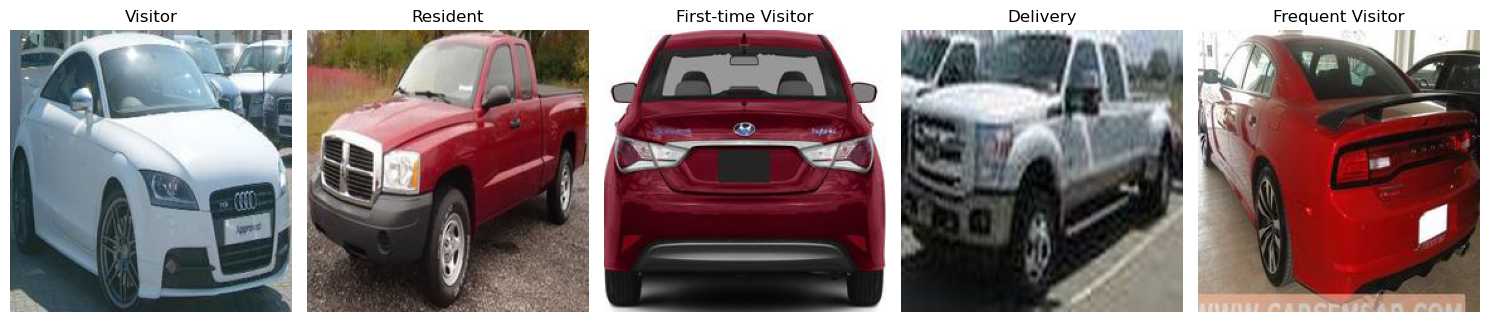

In [18]:
grouped_images = {}
for i, category in enumerate(predicted_categories):
    if category not in grouped_images:
        grouped_images[category] = []
    grouped_images[category].append(test_image_files[i])

# Plot one image from each category
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))

for i, (category, images) in enumerate(grouped_images.items()):
    # Choose the first image from each category
    image_path = images[0]
    img = plt.imread(image_path)

    # Plot the image
    axs[i].imshow(img)
    axs[i].set_title(category)
    axs[i].axis('off')

plt.tight_layout()
plt.show()
